In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/CASIA-Iris-Interval-20250617T034139Z-1-001.zip"  # Replace with your actual filename
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("unzipped_Iris-Interval")

In [14]:
import os
import shutil
import random

def get_all_images_recursive(class_path):
    images = []
    for root, _, files in os.walk(class_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                images.append(os.path.join(root, file))
    return images

def split_dataset(input_dir, output_dir, train_ratio=0.625, val_ratio=0.25, test_ratio=0.125):
    os.makedirs(output_dir, exist_ok=True)
    class_names = os.listdir(input_dir)

    for class_name in class_names:
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = get_all_images_recursive(class_path)
        random.shuffle(images)

        total = len(images)
        train_end = int(train_ratio * total)
        val_end = train_end + int(val_ratio * total)

        train_imgs = images[:train_end]
        val_imgs = images[train_end:val_end]
        test_imgs = images[val_end:]

        for split_name, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            split_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_dir, exist_ok=True)

            for img_path in split_imgs:
                img_name = os.path.basename(img_path)
                dst = os.path.join(split_dir, img_name)
                shutil.copy2(img_path, dst)

# ✅ Update your dataset paths
input_dataset_folder = "/content/unzipped_Iris-Interval/CASIA-Iris-Interval"
output_dataset_folder = "/content/split_dataset"

# ✅ Run
split_dataset(input_dataset_folder, output_dataset_folder)


In [ ]:
!pip install tensorflow

In [8]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import numpy as np

In [15]:
mg_height, img_width = (224,224)
batch_size = 16

train_data_dir = r"/content/split_dataset/train"
valid_data_dir = r"/content/split_dataset/val"
test_data_dir = r"/content/split_dataset/test"


In [16]:
import os

def count_images_in_directory(directory):
    total = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                total += 1
    return total



# Count and print
print(f" Number of training images: {count_images_in_directory(train_data_dir)}")
print(f" Number of validation images: {count_images_in_directory(valid_data_dir)}")
print(f" Number of test images: {count_images_in_directory(test_data_dir)}")


 Number of training images: 2159
 Number of validation images: 1002
 Number of test images: 944


In [17]:
train_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical') # set as training data

valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical') # set as validation data

Found 2159 images belonging to 240 classes.
Found 1002 images belonging to 240 classes.


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input  # or use VGG16's preprocess_input

# Define test image data generator
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Then use it here
test_generator = test_datagen.flow_from_directory(
    "/content/split_dataset/test",
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 944 images belonging to 240 classes.


In [19]:
x, y = next(test_generator)
x.shape

(16, 256, 256, 3)

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load ResNet50 with ImageNet weights, excluding top layer
base_model = ResNet50(include_top=False, weights='imagenet')

# Build custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all base model layers for initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile model for initial training
custom_optimizer = Adam(learning_rate=0.0002)
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_initial.h5', monitor='val_accuracy', save_best_only=True)

# Initial training
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,  # Initial training epochs
    callbacks=[early_stopping, checkpoint]
)

# Unfreeze selective layers for fine-tuning (last 10 layers, roughly conv5_x block)
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile model with lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for fine-tuning
checkpoint_finetune = ModelCheckpoint('best_model_finetuned.h5', monitor='val_accuracy', save_best_only=True)

# Fine-tuning training
history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,  # Fewer epochs for fine-tuning
    callbacks=[early_stopping, checkpoint_finetune]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.1397 - loss: 4.9628

135/135 ━━━━━━━━━━━━━━━━━━━━ 39s 179ms/step - accuracy: 0.1408 - loss: 4.9545 - val_accuracy: 0.7735 - val_loss: 2.3699
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8330 - loss: 1.0256

135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.8332 - loss: 1.0245 - val_accuracy: 0.9541 - val_loss: 0.6498
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9649 - loss: 0.3297

135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.9649 - loss: 0.3294 - val_accuracy: 0.9681 - val_loss: 0.2498
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9919 - loss: 0.1503

135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.9919 - loss: 0.1502 - val_accuracy: 0.9731 - val_loss: 0.1595
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 0.9954 - loss: 0.0805 - val_accuracy: 0.9721 - val_loss: 0.1321
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9975 - loss: 0.0545

135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.9975 - loss: 0.0545 - val_accuracy: 0.9780 - val_loss: 0.1195
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.9994 - loss: 0.0369 - val_accuracy: 0.9760 - val_loss: 0.1107
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 1.0000 - loss: 0.0283 - val_accuracy: 0.9760 - val_loss: 0.1063
Epoch 9/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.9986 - loss: 0.0216 - val_accuracy: 0.9760 - val_loss: 0.1004
Epoch 10/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0161

135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 1.0000 - loss: 0.0161 - val_accuracy: 0.9790 - val_loss: 0.0956
Epoch 11/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0146

135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 1.0000 - loss: 0.0146 - val_accuracy: 0.9800 - val_loss: 0.0931
Epoch 12/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.9992 - loss: 0.0135 - val_accuracy: 0.9800 - val_loss: 0.0928
Epoch 13/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 1.0000 - loss: 0.0104 - val_accuracy: 0.9790 - val_loss: 0.0940
Epoch 14/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0086

135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - accuracy: 1.0000 - loss: 0.0086 - val_accuracy: 0.9810 - val_loss: 0.0890
Epoch 15/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0088

135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 1.0000 - loss: 0.0088 - val_accuracy: 0.9830 - val_loss: 0.0849
Epoch 16/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.9820 - val_loss: 0.0852
Epoch 17/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.9800 - val_loss: 0.0855
Epoch 18/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 0.9810 - val_loss: 0.0852
Epoch 19/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.9810 - val_loss: 0.0833
Epoch 20/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9810 - val_loss: 0.0838
Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9976 - loss: 0.0300

135/135 ━━━━━━━━━━━━━━━━━━━━ 40s 188ms/step - accuracy: 0.9976 - loss: 0.0300 - val_accuracy: 0.9800 - val_loss: 0.0894
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0203

135/135 ━━━━━━━━━━━━━━━━━━━━ 23s 101ms/step - accuracy: 1.0000 - loss: 0.0203 - val_accuracy: 0.9810 - val_loss: 0.0890
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.9996 - loss: 0.0140 - val_accuracy: 0.9810 - val_loss: 0.0873
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 1.0000 - loss: 0.0103 - val_accuracy: 0.9810 - val_loss: 0.0859
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0095

135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 1.0000 - loss: 0.0095 - val_accuracy: 0.9820 - val_loss: 0.0827
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.9810 - val_loss: 0.0815
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 1.0000 - loss: 0.0078 - val_accuracy: 0.9810 - val_loss: 0.0804
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 1.0000 - loss: 0.0061 - val_accuracy: 0.9810 - val_loss: 0.0794
Epoch 9/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.9810 - val_loss: 0.0791
Epoch 10/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.9800 - val_loss: 0.0768


In [21]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("\nTest accuracy:", test_acc)

59/59 - 3s - 54ms/step - accuracy: 0.9693 - loss: 0.1530

Test accuracy: 0.9692796468734741


In [22]:
!mkdir -p /content/drive/MyDrive/Iris_Model1

In [23]:
model.save('/content/drive/MyDrive/Iris_Model1/ResNet50_Iris3.h5')

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, f1_score, recall_score
import seaborn as sns
from tqdm import tqdm
import os
import datetime

def evaluate_model(model_path, test_dir, target_size=(256, 256), output_dir="evaluation_results"):
    """
    Evaluate a trained model on test data with comprehensive metrics and visualizations.
    Includes detailed debugging for confusion matrix issues.
    """
    try:
        # Create output directory
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Load model
        try:
            model = load_model(model_path)
            print("Model loaded successfully")
        except Exception as e:
            print(f"Error loading model: {str(e)}")
            return

        # Create test data generator with consistent target size
        test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=target_size,
            batch_size=16,
            class_mode='categorical',
            shuffle=False
        )
        print(f"Found {test_generator.samples} images belonging to {len(test_generator.class_indices)} classes.")

        # Create index-to-class mapping
        class_indices = test_generator.class_indices
        index_to_class = {v: k for k, v in class_indices.items()}
        class_labels = list(class_indices.keys())
        print(f"Class indices: {class_indices}")

        # Evaluate model to get a baseline
        test_loss, test_acc = model.evaluate(test_generator, verbose=2)
        print(f"\nTest accuracy: {test_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}")

        # Make predictions with explicit steps
        test_generator.reset()
        num_samples = test_generator.samples
        predictions = model.predict(test_generator, steps=int(num_samples / test_generator.batch_size), verbose=1)
        predicted_classes = np.argmax(predictions[:num_samples], axis=1)  # Ensure length matches
        true_classes = test_generator.classes[:num_samples]

        # Debugging prints
        print(f"Number of true classes: {len(true_classes)}")
        print(f"Number of predicted classes: {len(predicted_classes)}")
        print(f"Sample predictions: {predicted_classes[:10]}")
        print(f"Sample true classes: {true_classes[:10]}")
        print(f"Max prediction value: {np.max(predictions)}")
        print(f"Min prediction value: {np.min(predictions)}")

        # Verify and adjust lengths
        if len(true_classes) != len(predicted_classes):
            print(f"Warning: Mismatch in lengths - True: {len(true_classes)}, Predicted: {len(predicted_classes)}")
            min_length = min(len(true_classes), len(predicted_classes))
            true_classes = true_classes[:min_length]
            predicted_classes = predicted_classes[:min_length]
        else:
            print("Lengths match successfully")

        # Calculate confusion matrix
        cm = confusion_matrix(true_classes, predicted_classes)
        print(f"Confusion matrix shape: {cm.shape}")
        print(f"Confusion matrix content:\n{cm}")

        # Plot full confusion matrix for first 10 classes
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm[:10, :10], annot=True, fmt='d', cmap='Blues',  # Limit to 10x10 for readability
                    xticklabels=class_labels[:10],
                    yticklabels=class_labels[:10])
        plt.title('Confusion Matrix (First 10 Classes)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
        plt.close()

        macro_precision = precision_score(true_classes, predicted_classes, average="macro", zero_division=0)
        macro_recall    = recall_score   (true_classes, predicted_classes, average="macro", zero_division=0)
        macro_f1        = f1_score       (true_classes, predicted_classes, average="macro", zero_division=0)

        # Calculate and save classification report
        print("\nClassification Report:")
        print(classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0))
        with open(os.path.join(output_dir, 'classification_report.txt'), 'w') as f:
            f.write(classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0))

        # Save overall metrics
        accuracy = np.mean(predicted_classes == true_classes)
        metrics = {
            'test_accuracy': test_acc,
            'test_loss': test_loss,
            'overall_accuracy': accuracy,
            'timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        with open(os.path.join(output_dir, 'metrics.txt'), 'w') as f:
            for key, value in metrics.items():
                f.write(f"{key}: {value}\n")

        print(f"\nOverall Accuracy: {accuracy:.4f}")
        print(f"Evaluation results saved in {output_dir}")
        print(f"Macro Precision  : {macro_precision:.4f}")
        print(f"Macro Recall     : {macro_recall:.4f}")
        print(f"Macro F1-score   : {macro_f1:.4f}")

    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")

if __name__ == "__main__":
    model_path = '/content/drive/MyDrive/Iris_Model1/ResNet50_Iris3.h5'
    test_dir = "/content/split_dataset/test"
    evaluate_model(model_path, test_dir, target_size=(256, 256))

Model loaded successfully
Found 944 images belonging to 240 classes.
Found 944 images belonging to 240 classes.
Class indices: {'001': 0, '002': 1, '003': 2, '004': 3, '005': 4, '006': 5, '007': 6, '008': 7, '009': 8, '010': 9, '011': 10, '012': 11, '013': 12, '014': 13, '015': 14, '016': 15, '017': 16, '018': 17, '019': 18, '020': 19, '021': 20, '022': 21, '023': 22, '024': 23, '025': 24, '026': 25, '027': 26, '028': 27, '029': 28, '030': 29, '031': 30, '032': 31, '033': 32, '034': 33, '035': 34, '036': 35, '037': 36, '038': 37, '039': 38, '040': 39, '041': 40, '042': 41, '043': 42, '044': 43, '045': 44, '046': 45, '047': 46, '048': 47, '049': 48, '050': 49, '051': 50, '052': 51, '053': 52, '054': 53, '055': 54, '056': 55, '057': 56, '058': 57, '059': 58, '060': 59, '061': 60, '062': 61, '063': 62, '064': 63, '065': 64, '066': 65, '067': 66, '068': 67, '069': 68, '070': 69, '071': 70, '072': 71, '073': 72, '074': 73, '075': 74, '076': 75, '077': 76, '078': 77, '079': 78, '080': 79, '0

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


59/59 - 8s - 141ms/step - accuracy: 0.9693 - loss: 0.1530

Test accuracy: 0.9693
Test loss: 0.1530
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step
Number of true classes: 944
Number of predicted classes: 944
Sample predictions: [0 0 0 0 0 0 1 9 1 9]
Sample true classes: [0 0 0 0 0 0 1 1 1 1]
Max prediction value: 0.9999997615814209
Min prediction value: 5.341455939834622e-16
Lengths match successfully
Confusion matrix shape: (240, 240)
Confusion matrix content:
[[6 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 0]]

Classification Report:
              precision    recall  f1-score   support

         001       1.00      1.00      1.00         6
         002       1.00      0.60      0.75         5
         003       1.00      1.00      1.00         3
         004       1.00      1.00      1.00         3
         005       1.00      1.00      1.00         2
         006       1.00      1.00      1.00         4
         007       

    epoch  accuracy  val_accuracy      loss  val_loss  learning_rate
0       1  0.299676      0.773453  3.833196  2.369851        0.00001
1       2  0.855952      0.954092  0.870938  0.649841        0.00001
2       3  0.967578      0.968064  0.290055  0.249787        0.00001
3       4  0.992126      0.973054  0.132937  0.159498        0.00001
4       5  0.994905      0.972056  0.076444  0.132136        0.00001
5       6  0.997684      0.978044  0.051573  0.119497        0.00001
6       7  0.999074      0.976048  0.036134  0.110700        0.00001
7       8  1.000000      0.976048  0.028778  0.106259        0.00001
8       9  0.999074      0.976048  0.022689  0.100375        0.00001
9      10  1.000000      0.979042  0.016305  0.095569        0.00001
10     11  1.000000      0.980040  0.015527  0.093108        0.00001
11     12  0.999074      0.980040  0.014495  0.092755        0.00001
12     13  1.000000      0.979042  0.011180  0.094022        0.00001
13     14  1.000000      0.981038 

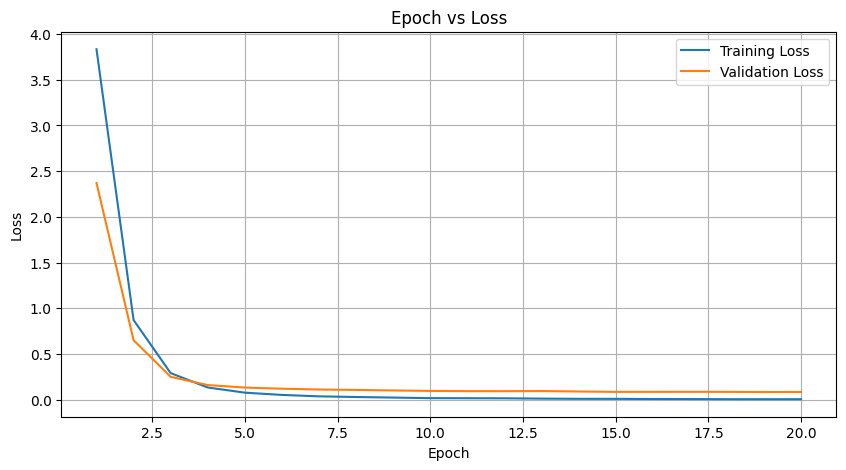

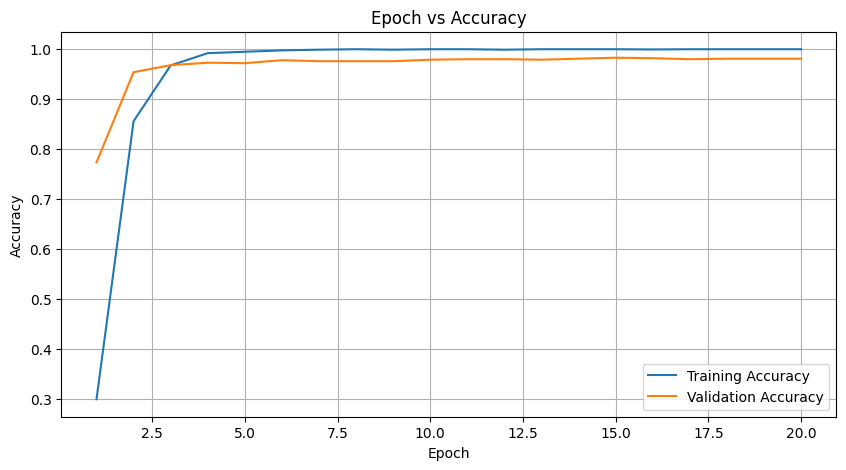

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Create a results dictionary from history object
results = {
    'epoch': list(range(1, len(history.history['accuracy']) + 1)),
    'accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'],
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'learning_rate': [float(tf.keras.backend.get_value(model.optimizer.learning_rate))] * len(history.history['accuracy'])
}

# Create a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Save to CSV (optional)
results_df.to_csv("evaluation_results/training_metrics_table.csv", index=False)

# Plot Epoch vs. Loss
plt.figure(figsize=(10, 5))
plt.plot(results['epoch'], results['loss'], label='Training Loss')
plt.plot(results['epoch'], results['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid(True)
plt.savefig("evaluation_results/epoch_vs_loss.png")
plt.show()

# Plot Epoch vs. Accuracy
plt.figure(figsize=(10, 5))
plt.plot(results['epoch'], results['accuracy'], label='Training Accuracy')
plt.plot(results['epoch'], results['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("evaluation_results/epoch_vs_accuracy.png")
plt.show()